In [ ]:
import gdown
file_id = '1MAXmmYzW1WUUDyNZBCiZNdP2njZFHUL0'
file_path = '/content/dataset.zip'

gdown.download(f'https://drive.google.com/uc?id={file_id}', file_path, quiet=False)
!unzip /content/dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1MAXmmYzW1WUUDyNZBCiZNdP2njZFHUL0
To: /content/dataset.zip
100%|██████████| 56.4M/56.4M [00:00<00:00, 116MB/s]


Archive:  /content/dataset.zip
  inflating: categories.npy          
  inflating: training_data.npy       
  inflating: valid_periods.npy       


In [ ]:
import numpy as np
categories = np.load('./categories.npy')
categories.shape

(48000,)

In [ ]:
valid_periods = np.load('./valid_periods.npy')
valid_periods.shape

(48000, 2)

In [ ]:
for period in valid_periods:
  if period[0] < 2500:
    period[0] = 2500

In [ ]:
min, max = (9999, -1), (0, -1)
for i, tuple in enumerate(valid_periods):
    diff = tuple[1] - tuple[0]
    if diff < min[0]: min = (diff, i)
    if diff > max[0]: max = (diff, i)

min, max

((24, 47852), (2776, 17143))

In [ ]:
training_data = np.load('./training_data.npy')
training_data.shape

(48000, 2776)

In [ ]:
import pandas as pd
training_data_df = pd.DataFrame(training_data)
training_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float64(2776)
memory usage: 1016.6 MB


In [ ]:
category_counts = np.unique(categories, return_counts=True)
for category, count in zip(category_counts[0], category_counts[1]):
    print(f"Category {category}: {count}")

Category A: 5728
Category B: 10987
Category C: 10017
Category D: 10016
Category E: 10975
Category F: 277


In [ ]:
from sklearn.preprocessing import RobustScaler

# Assuming 'data' is your numpy array
scaler = RobustScaler()
scaled_data = scaler.fit_transform(training_data[:,2500:])

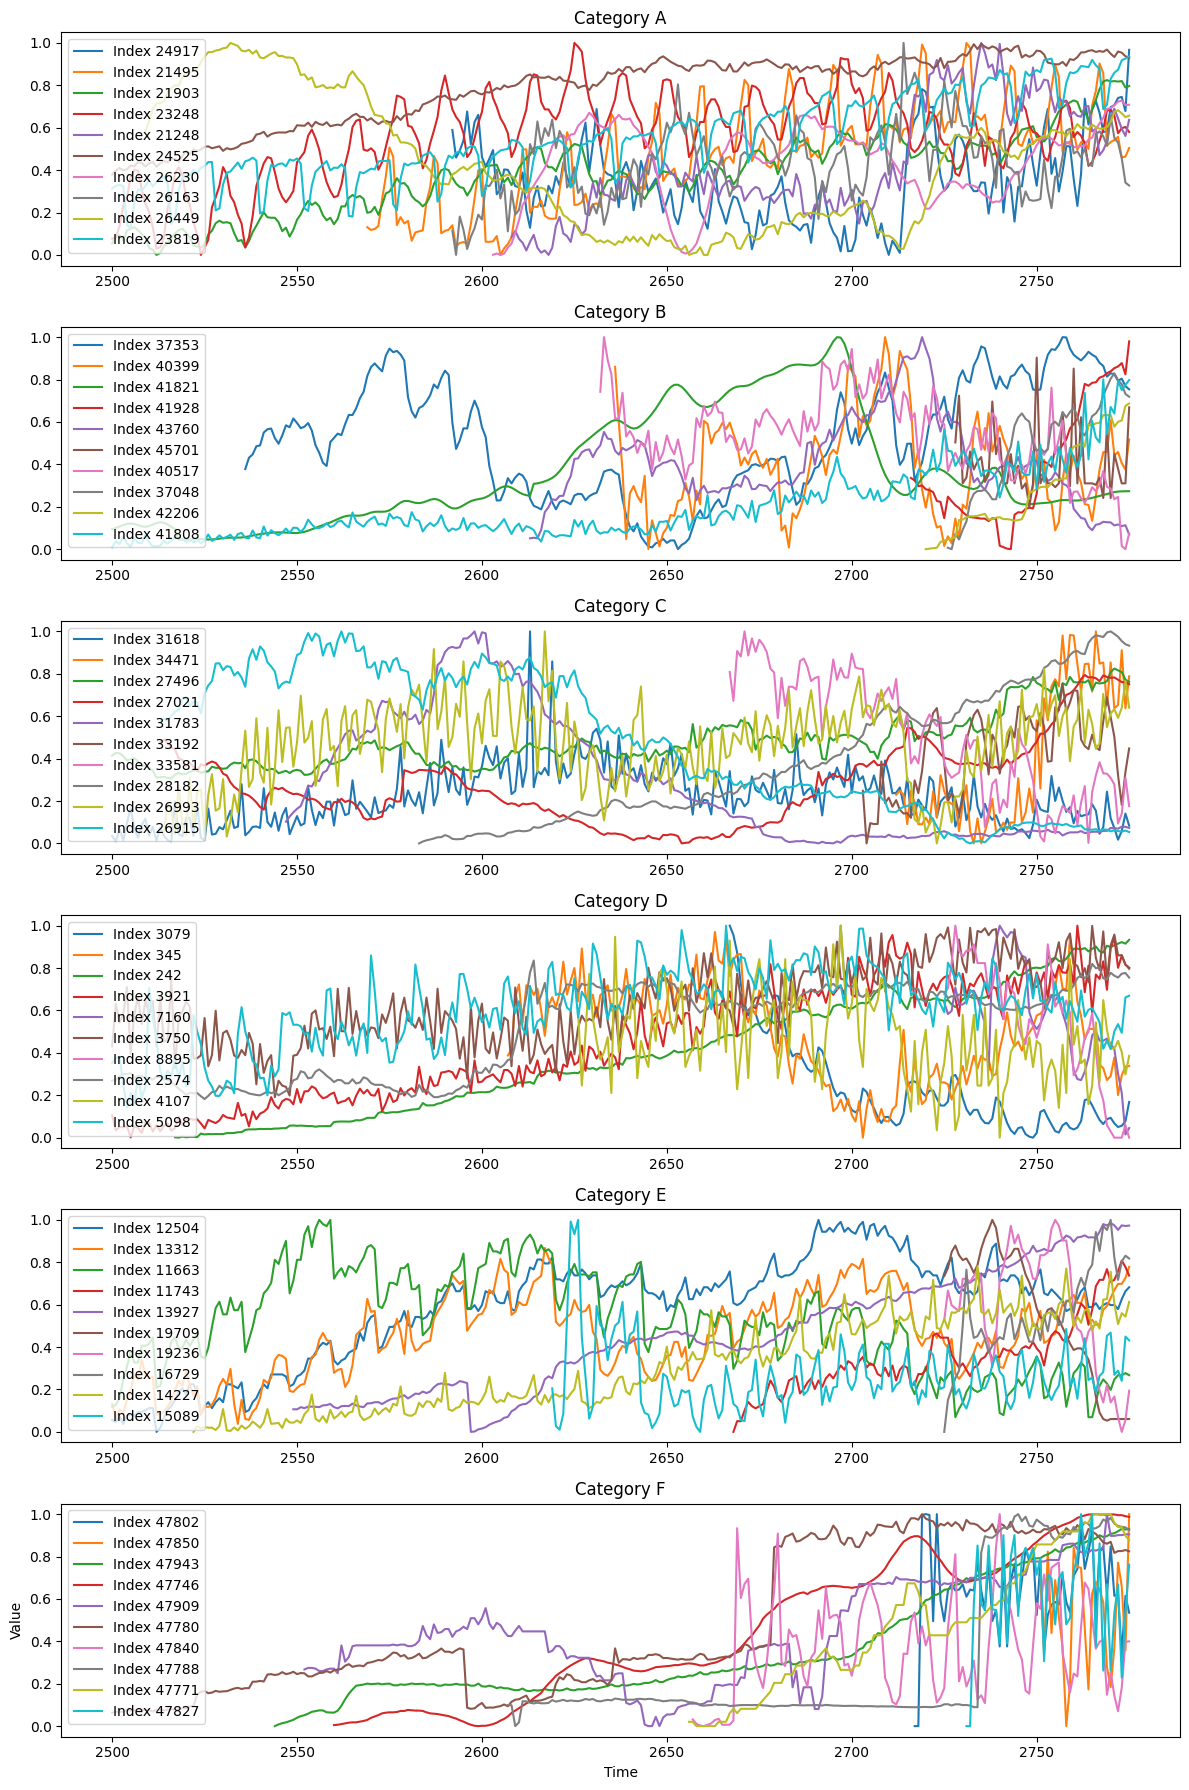

In [ ]:
# Plot 10 time series for each category
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(12, 18))
for i, category in enumerate(np.unique(categories)):
    # Get the indices of the time series for this category
    indices = np.where(categories == category)[0]
    # Randomly choose 10 indices from this category
    chosen_indices = np.random.choice(indices, 10, replace=False)

    for ts_index in chosen_indices:
        # Find the valid period for this time series
        start, end = valid_periods[ts_index]
        # Plot the time series data for its valid period
        axes[i].plot(range(start, end), training_data[ts_index, start:end], label=f'Index {ts_index}')

    axes[i].set_title(f'Category {category}')
    axes[i].legend()

plt.xlabel('Time')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
reshaped_categories = categories.reshape(-1, 1)
onehot_categories = encoder.fit_transform(reshaped_categories)

onehot_categories

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [ ]:
from sklearn.model_selection import train_test_split

# Split the indices of the time series into training and validation sets
train_indices, val_indices = train_test_split(np.arange(len(training_data_df)), test_size=0.2, random_state=42, stratify=categories)

# Use these indices to create training and validation sets
train_set = training_data_df.iloc[train_indices]
valid_periods_train = valid_periods[train_indices]
onehot_categories_train = onehot_categories[train_indices]

val_set = training_data_df.iloc[val_indices]
valid_periods_val = valid_periods[val_indices]
onehot_categories_val = onehot_categories[val_indices]

train_set.shape, valid_periods_train.shape, onehot_categories_train.shape, val_set.shape, valid_periods_val.shape, onehot_categories_val.shape

((38400, 2776), (38400, 2), (38400, 6), (9600, 2776), (9600, 2), (9600, 6))

In [ ]:
def calculate_padding_length(sq, w, t, s):
    cycle = w + t
    if sq <= cycle: return cycle - sq
    else:
        m = (sq - cycle) % s
        if m == 0: return m
        else: return s - m

In [ ]:
def create_sequences(df, valid_periods, categories, window, telescope, stride=1):

    input_sequences = []
    input_categories = []
    output_sequences = []


    for i in range(len(valid_periods)):
        start, end = valid_periods[i]
        category = categories[i]

        sequence = df.iloc[i, start:end].values

        padding_length = calculate_padding_length(len(sequence), window, telescope, stride)
        sequence = np.pad(sequence, (padding_length, 0), mode='constant', constant_values=0)

        for j in range(0, len(sequence) - window - telescope + 1, stride):
            input_seq = sequence[j:(j + window)]
            output_seq = sequence[(j + window):(j + window + telescope)]

            input_sequences.append(input_seq)
            input_categories.append(category)
            output_sequences.append(output_seq)

    return np.array(input_sequences), np.array(input_categories), np.array(output_sequences)

In [ ]:
window = 100
telescope = 9
stride = 10

In [ ]:
X_train, X_train_category, y_train = create_sequences(train_set, valid_periods_train, onehot_categories_train, window, telescope, stride)
X_val, X_val_category, y_val = create_sequences(val_set, valid_periods_val, onehot_categories_val, window, telescope, stride)
X_train.shape, X_train_category.shape, y_train.shape, X_val.shape, X_val_category.shape, y_val.shape

((365024, 100), (365024, 6), (365024, 9), (91086, 100), (91086, 6), (91086, 9))

In [ ]:
input_shape = (window, 1)
category_shape = (6, )
output_shape = (telescope, 1)
batch_size = 32
epochs = 200

In [ ]:
import tensorflow.keras.layers as tfkl
import tensorflow as tf

def build_CONV_LSTM_model_with_categories(input_shape, category_shape, output_shape):

    # Time series input
    time_series_input = tfkl.Input(shape=input_shape, name='time_series_input')
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='bidirectional_lstm'))(time_series_input)
    x = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True, name='bidirectional_lstm_2'))(x)

    # Attention mechanism
    attention = tfkl.Attention(name='attention')([x, x])

    x = tfkl.Conv1D(128, 3, padding='same', activation='relu')(attention)
    x = tfkl.Dropout(0.2)(x)

    # Category input
    category_input = tfkl.Input(shape=category_shape, name='category_input')
    category_processed = tfkl.Dense(20, activation='relu')(category_input)

    # Combine the processed inputs
    combined = tfkl.Concatenate()([x, tfkl.RepeatVector(input_shape[0])(category_processed)])

    # Continue with convolutional layers
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu')(combined)
    x = tfkl.Dropout(0.2)(x)

    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same')(x)
    crop_size = output_layer.shape[1] - output_shape[0]
    output_layer = tfkl.Cropping1D((0, crop_size))(output_layer)

    # Construct the model
    model = tf.keras.Model(inputs=[time_series_input, category_input], outputs=output_layer, name='CONV_LSTM_with_Categories')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(1e-3))

    return model

In [ ]:
model = build_CONV_LSTM_model_with_categories(input_shape, category_shape, output_shape)

Model: "CONV_LSTM_with_Categories"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 time_series_input (InputLa  [(None, 100, 1)]             0         []                            
 yer)                                                                                             
                                                                                                  
 bidirectional_8 (Bidirecti  (None, 100, 128)             33792     ['time_series_input[0][0]']   
 onal)                                                                                            
                                                                                                  
 bidirectional_9 (Bidirecti  (None, 100, 64)              41216     ['bidirectional_8[0][0]']     
 onal)                                                                    

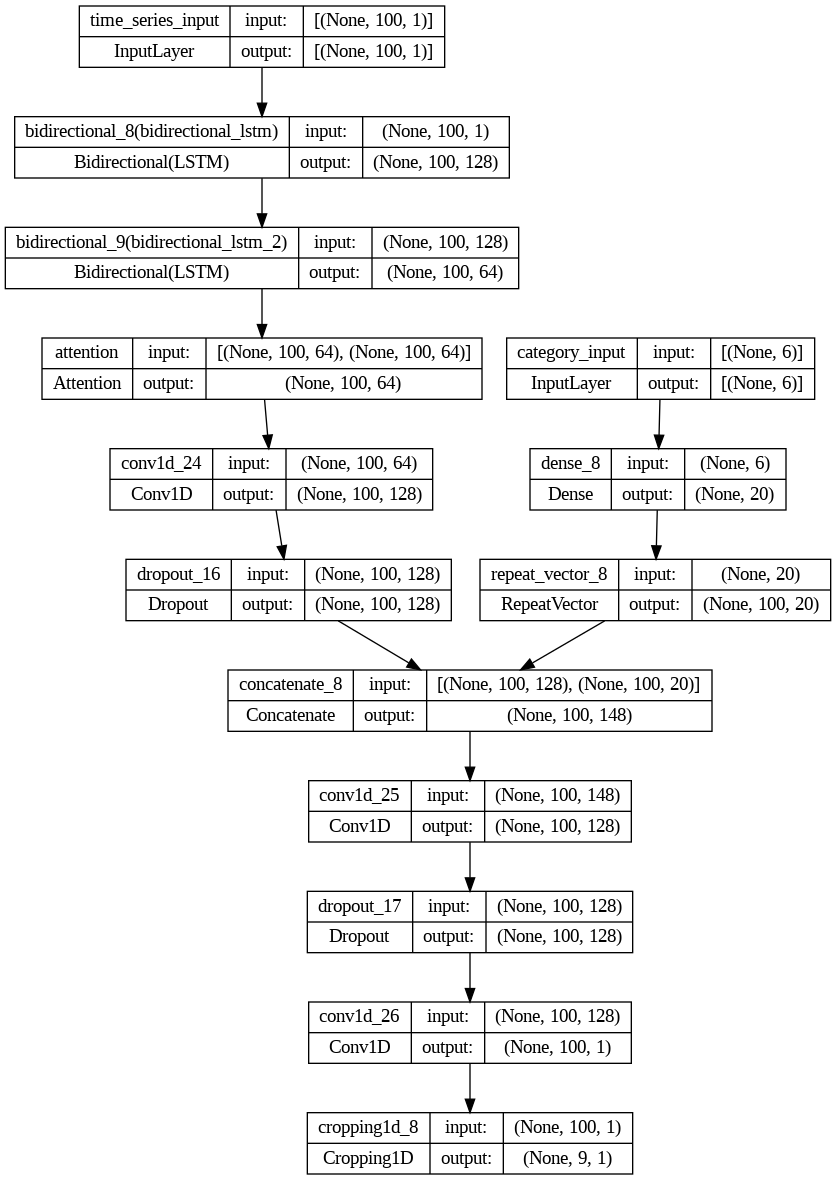

In [ ]:
model.summary()

from tensorflow import keras as tfk
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=15,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    patience=10,
    factor=0.1,
    min_lr=1e-5
)

history = model.fit(
    x = [X_train, X_train_category],
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = ([X_val, X_val_category], y_val),
    callbacks = [
        early_stopping,
        reduce_lr
    ]
).history

Epoch 1/200
11407/11407 [==============================] - 289s 25ms/step - loss: 0.0140 - val_loss: 0.0111 - lr: 0.0010
Epoch 2/200
11407/11407 [==============================] - 257s 23ms/step - loss: 0.0113 - val_loss: 0.0103 - lr: 0.0010
Epoch 3/200
11407/11407 [==============================] - 256s 22ms/step - loss: 0.0102 - val_loss: 0.0092 - lr: 0.0010
Epoch 4/200
11407/11407 [==============================] - 253s 22ms/step - loss: 0.0099 - val_loss: 0.0089 - lr: 0.0010
Epoch 5/200
11407/11407 [==============================] - 252s 22ms/step - loss: 0.0094 - val_loss: 0.0088 - lr: 0.0010
Epoch 6/200
11407/11407 [==============================] - 253s 22ms/step - loss: 0.0091 - val_loss: 0.0087 - lr: 0.0010
Epoch 7/200
11407/11407 [==============================] - 253s 22ms/step - loss: 0.0090 - val_loss: 0.0086 - lr: 0.0010
Epoch 8/200
11407/11407 [==============================] - 254s 22ms/step - loss: 0.0088 - val_loss: 0.0083 - lr: 0.0010
Epoch 9/200
11407/11407 [=======

In [ ]:
#Previous Run

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=15,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    patience=10,
    factor=0.1,
    min_lr=1e-5
)

history = model.fit(
    x = [X_train, X_train_category],
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = ([X_val, X_val_category], y_val),
    callbacks = [
        early_stopping,
        reduce_lr
    ]
).history

Epoch 1/200
3932/3932 [==============================] - 68s 15ms/step - loss: 0.0179 - val_loss: 0.0126 - lr: 0.0010
Epoch 2/200
3932/3932 [==============================] - 54s 14ms/step - loss: 0.0123 - val_loss: 0.0114 - lr: 0.0010
Epoch 3/200
3932/3932 [==============================] - 53s 13ms/step - loss: 0.0110 - val_loss: 0.0105 - lr: 0.0010
Epoch 4/200
3932/3932 [==============================] - 52s 13ms/step - loss: 0.0104 - val_loss: 0.0101 - lr: 0.0010
Epoch 5/200
3932/3932 [==============================] - 52s 13ms/step - loss: 0.0168 - val_loss: 0.0111 - lr: 0.0010
Epoch 6/200
3932/3932 [==============================] - 53s 13ms/step - loss: 0.0101 - val_loss: 0.0107 - lr: 0.0010
Epoch 7/200
3932/3932 [==============================] - 53s 13ms/step - loss: 0.0099 - val_loss: 0.0102 - lr: 0.0010
Epoch 8/200
3932/3932 [==============================] - 53s 13ms/step - loss: 0.0097 - val_loss: 0.0094 - lr: 0.0010
Epoch 9/200
3932/3932 [==============================] -

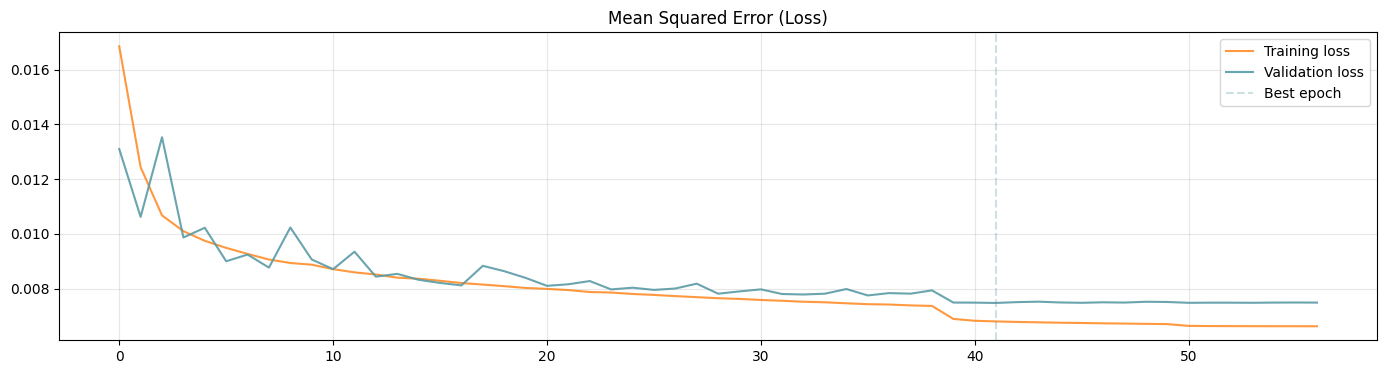

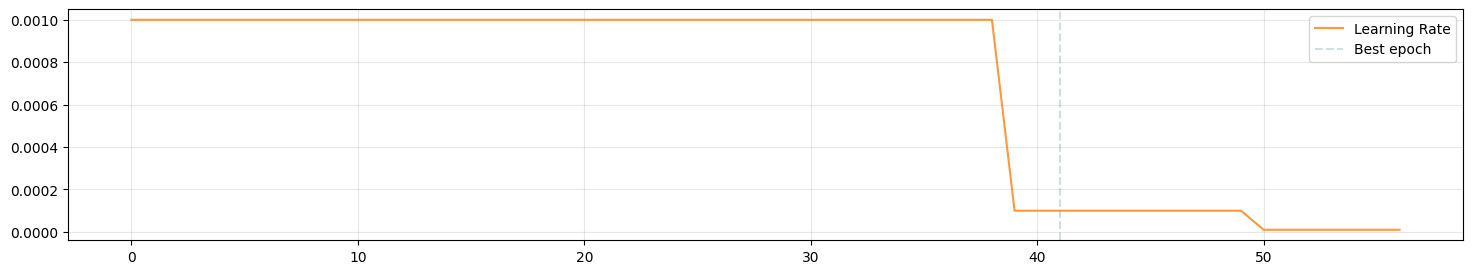

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
preds = model.predict([X_val, X_val_category])

1984/1984 [==============================] - 17s 7ms/step


In [ ]:
preds.shape

(63460, 9, 1)

In [ ]:
model.save('conv_lstm_tp9_ws100_att')

In [ ]:
!zip model.zip -r conv_lstm_tp9_ws100_att/

  adding: conv_lstm_tp9_ws100_att/ (stored 0%)
  adding: conv_lstm_tp9_ws100_att/assets/ (stored 0%)
  adding: conv_lstm_tp9_ws100_att/variables/ (stored 0%)
  adding: conv_lstm_tp9_ws100_att/variables/variables.index (deflated 64%)
  adding: conv_lstm_tp9_ws100_att/variables/variables.data-00000-of-00001 (deflated 29%)
  adding: conv_lstm_tp9_ws100_att/saved_model.pb (deflated 90%)
  adding: conv_lstm_tp9_ws100_att/fingerprint.pb (stored 0%)
  adding: conv_lstm_tp9_ws100_att/keras_metadata.pb (deflated 92%)
